# **Running Hive on Pyspark in Colab**

Prepare PySpark Cluster

In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# OR

In [2]:
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Define the path to your Spark archive on Google Drive
spark_archive_path = '/content/drive/MyDrive/Datasets/spark-3.0.0-bin-hadoop3.2.tgz'

# Copy the Spark archive from Google Drive to your Colab environment
!cp "$spark_archive_path" .

# Extract the Spark archive (be sure to use the correct filename)
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Set your Spark folder to your system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# Install findspark using pip
!pip install -q findspark

# Run a local spark session to test your installation

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

# Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installed and imported required libraries

In [4]:
import pyspark
from pyspark.sql.functions import countDistinct, col, mean
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.sql.functions import when

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, FMClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Load bank data to Spark Cluster

In [7]:
bdf = spark.read.option("inferSchema", "true").csv('/content/drive/MyDrive/Datasets/bank.csv', header=True)

In [8]:
bdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [9]:
print(f"Total number of observations: {bdf.count()}")
print(f"Total number of variables: {len(bdf.columns)}")

Total number of observations: 11162
Total number of variables: 17


# Displaying top5 rows data

In [10]:
bdf.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [11]:
import pandas as pd

pd.DataFrame(bdf.take(5), columns=bdf.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


# Checking the split of "deposit" field in our data

In [12]:
from pyspark.sql.functions import count

# Group by 'deposit' column and count the occurrences
grouped_counts = bdf.groupBy('deposit').agg(count('*').alias('count'))

# Show the result
grouped_counts.show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [13]:
bdf.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

# Discriptive statistics of numerical columns

In [14]:
# Filter columns of integer type
int_columns = [col for col, dtype in bdf.dtypes if dtype == 'int']

# Select and describe the integer columns
summary = bdf.select(int_columns).describe()

summary.show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|             -6847|                 1|                 2|                 1|                -1|                 0|

In [15]:
num_features = [t[0] for t in bdf.dtypes if t[1] == 'int']
bdf.select(num_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


# NA values check

In [16]:
from pyspark.sql.functions import col, sum

# Create a list of columns you want to check for missing values
columns_to_check = bdf.columns

# Use a list comprehension to calculate the count of missing values for each column
missing_counts = [sum(col(c).isNull().cast("int")).alias(c) for c in columns_to_check]

# Apply aggregation to get the count of missing values for each column
missing_counts_result = bdf.agg(*missing_counts)

# Show the results
missing_counts_result.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|      0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+



# Removing Outliers of numerical fields

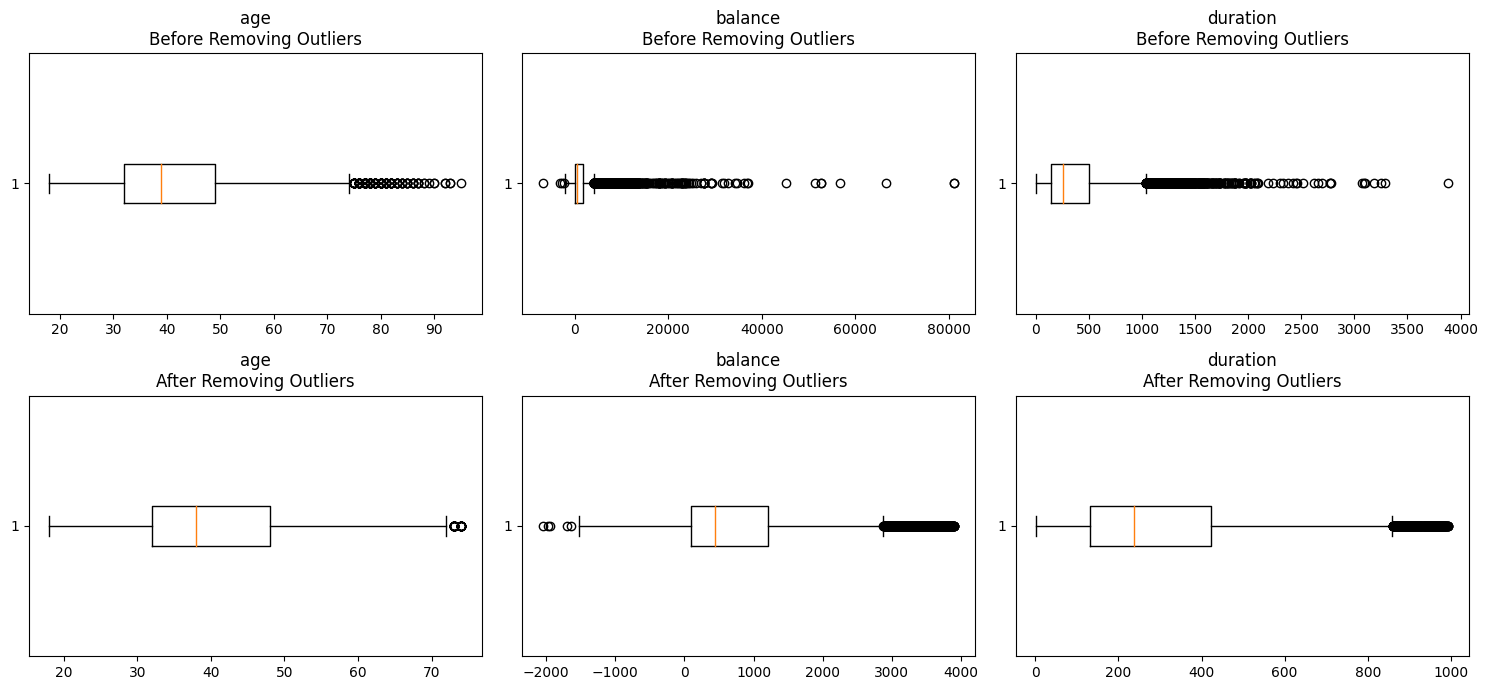

In [17]:
# Specifying the numerical columns that we want to work with
numerical_columns = ["age", "balance", "duration"]

# Dictionary to store outliers and data frames after removing outliers
outliers_data = {}
no_outliers_data = {}

# Loop through each numerical column
for column_name in numerical_columns:
    # Calculate the Q1 and Q3 quantiles
    q1 = bdf.approxQuantile(column_name, [0.25], 0.01)[0]
    q3 = bdf.approxQuantile(column_name, [0.75], 0.01)[0]

    # Calculate the IQR
    iqr = q3 - q1

    # Define the lower and upper bounds for potential outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Display potential outliers
    outliers = bdf.filter((col(column_name) < lower_bound) | (col(column_name) > upper_bound))
    outliers_data[column_name] = outliers

    # Remove outliers
    bdf_no_outliers = bdf.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))
    no_outliers_data[column_name] = bdf_no_outliers

# Create a 2xN grid of subplots
n = len(numerical_columns)
fig, axes = plt.subplots(2, n, figsize=(15, 7))

# Loop through the numerical columns
for i, column_name in enumerate(numerical_columns):
    # Create box plot for data before removing outliers (top row)
    data_before_outliers = bdf.select(column_name).toPandas()
    axes[0, i].boxplot(data_before_outliers, vert=False)
    axes[0, i].set_title(f'{column_name}\nBefore Removing Outliers')

    # Create box plot for data after removing outliers (bottom row)
    data_after_outliers = no_outliers_data[column_name].select(column_name).toPandas()
    axes[1, i].boxplot(data_after_outliers, vert=False)
    axes[1, i].set_title(f'{column_name}\nAfter Removing Outliers')

# Adjust subplot layout and display the plot
plt.tight_layout()
plt.show()

In [18]:
print(f"Total number of observations after removing outliers: {bdf_no_outliers.count()}")
print(f"Total number of variables after removing outliers: {len(bdf_no_outliers.columns)}")

Total number of observations after removing outliers: 10444
Total number of variables after removing outliers: 17


# Checking distribution of numerical fields

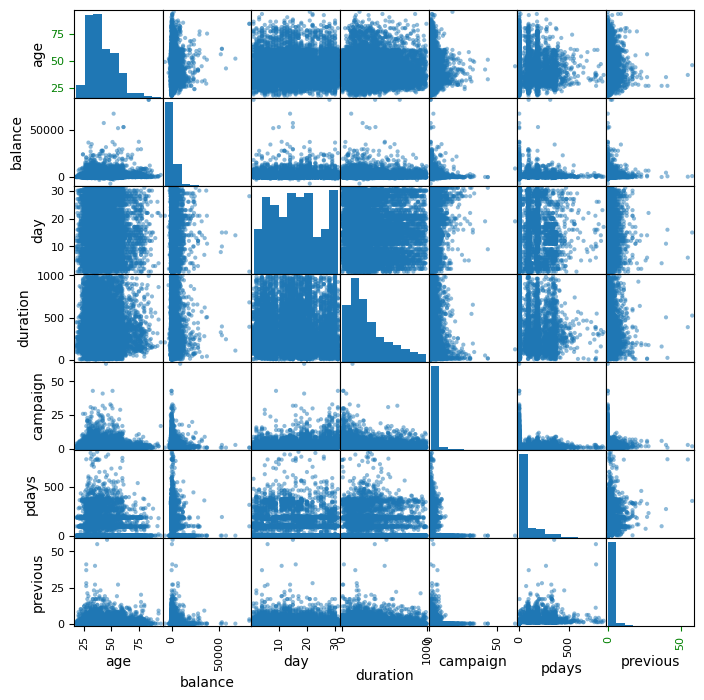

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter columns of numeric data type (int or double)
num_features = [t[0] for t in bdf_no_outliers.dtypes if t[1] in ('int', 'double')]

# Select the numeric columns
numeric_data = bdf_no_outliers.select(num_features).toPandas()

# Create a scatter matrix plot with customized colors
scatter_matrix = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))

# Modify histogram colors and border colors
for i in range(len(numeric_data.columns)):
    for j in range(len(numeric_data.columns)):
        if i != j:
            ax = scatter_matrix[i, j]
            ax.spines['bottom'].set_color('black')
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['left'].set_color('black')

        if i == j:
            # Histograms in the diagonal
            ax = scatter_matrix[i, i]
            ax.spines['bottom'].set_color('black')
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.tick_params(axis='x', colors='green')
            ax.tick_params(axis='y', colors='green')

plt.show()

# Distribution of Recent Bank-Customer Interaction Durations (in seconds)

In [20]:
bank_pandas = bdf_no_outliers.toPandas()

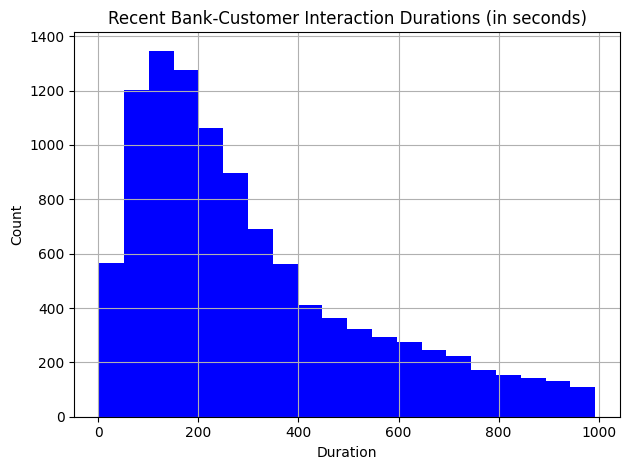

In [21]:
bank_pandas.hist(column='duration', bins=20, color="b")
plt.title("Recent Bank-Customer Interaction Durations (in seconds)")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Correlation Heatmap among numerical fields

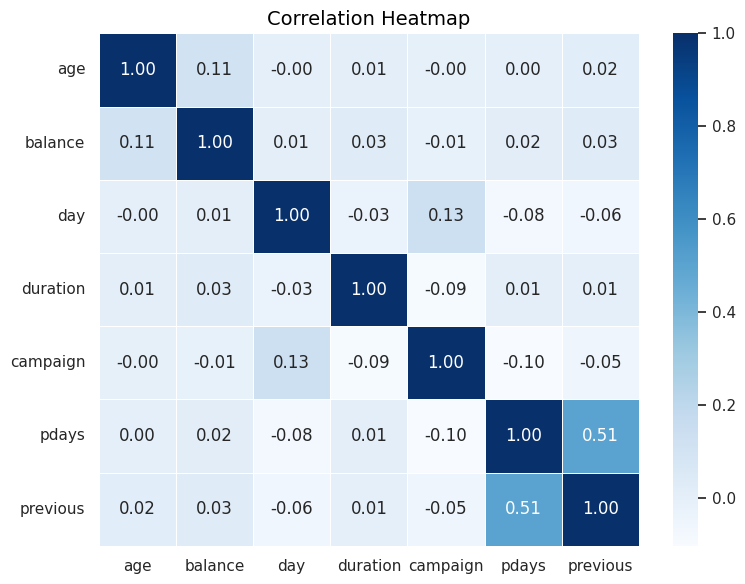

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter columns of numeric data type (int or double)
num_features = [t[0] for t in bdf_no_outliers.dtypes if t[1] in ('int', 'double')]

# Select the numeric columns
numeric_data = bdf_no_outliers.select(num_features).toPandas()

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Set the style and create the heatmap
sns.set(style="white")
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)

plt.title("Correlation Heatmap", color='black', size=14)
plt.tight_layout()
plt.show()

# Which specific days of the month are most suitable for successful marketing campaigns for term deposit subscriptions?

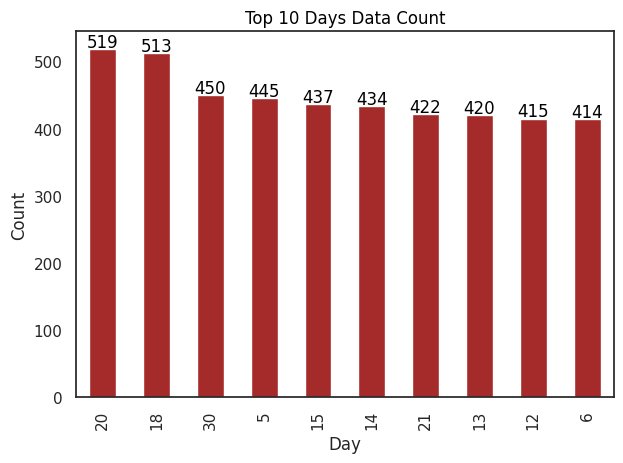

In [23]:
import matplotlib.pyplot as plt

# Assuming bank_pandas is your DataFrame

ax = bank_pandas['day'].value_counts().head(10).plot(kind='bar', color='brown', title='Top 10 days data count')
ax.set_xlabel('Day')
ax.set_ylabel('Count')
plt.title("Top 10 Days Data Count", color='black')
plt.tight_layout()

# Display peak values on each bar
for i, v in enumerate(bank_pandas['day'].value_counts().head(10)):
    ax.text(i, v + 3, str(v), color='black', ha='center')

plt.show()

# Can we identify any patterns or trends in the balance of customers based on the days they were contacted?

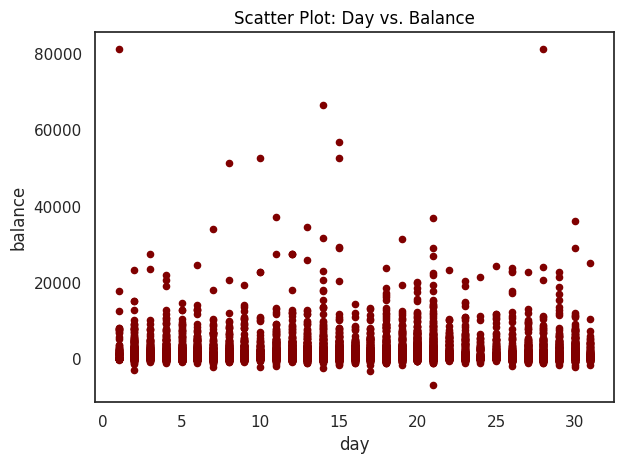

In [24]:
import matplotlib.pyplot as plt


bank_pandas.plot(kind='scatter', x='day', y='balance', c='maroon', title='balance')
plt.title("Scatter Plot: Day vs. Balance", color='black')
plt.tight_layout()
plt.show()

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr

correlation_value = bdf_no_outliers.select(corr('day', 'balance')).collect()[0][0]
print(f"Correlation between 'day' and 'balance' is: {correlation_value}")

Correlation between 'day' and 'balance' is: 0.010843734826431037


# Converting deposit field to labels (0 or 1)

In [26]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

# Create an empty list to store stages of the pipeline
stages = []

# Define a list of categorical columns that need preprocessing
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

# Loop through each categorical column to perform StringIndexing and OneHotEncoding
for categoricalCol in categoricalColumns:
    # Perform StringIndexing on the categorical column
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')

    # Perform OneHotEncoding on the StringIndexed column
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()],
        outputCols=[categoricalCol + "classVec"]
    )

    # Add StringIndexer and OneHotEncoder to the list of stages
    stages += [stringIndexer, encoder]

# Perform StringIndexing on the 'deposit' column to create the 'label'
label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')

# Add label StringIndexer to the list of stages
stages += [label_stringIdx]

# Define a list of numeric columns
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Create a list of input columns for the VectorAssembler, including the one-hot encoded categorical columns and numeric columns
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

# Use VectorAssembler to assemble all the input features into a single feature vector
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Add VectorAssembler to the list of stages
stages += [assembler]

In [27]:
from pyspark.ml import Pipeline

# Create a Pipeline object, defining the sequence of stages to be executed
pipeline = Pipeline(stages=stages)

# Fit the Pipeline to the input DataFrame 'bdf_no_outliers', which applies all defined stages in sequence
pipelineModel = pipeline.fit(bdf_no_outliers)

# Transform the input data using the fitted pipeline to prepare it for machine learning
# This includes all the preprocessing steps defined in 'stages'
bdf_no_outliers = pipelineModel.transform(bdf_no_outliers)

# Define a list of column names to keep in the DataFrame
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']

# Define a list of selected columns to keep in the DataFrame
selectedCols = ['label', 'features'] + cols

# Select only the specified columns from the DataFrame
bdf_no_outliers = bdf_no_outliers.select(selectedCols)

# Print the schema of the final DataFrame to check the structure of the selected columns
bdf_no_outliers.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



# Exploring the Dimensionality of the 'Features' Vector in the Transformed Dataset

In [28]:
pdf = pd.DataFrame(bdf_no_outliers.take(5), columns=bdf_no_outliers.columns)
pdf.iloc[:,0:2]

,label,features
0,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [29]:
len(pdf.features[0])

30

# Machine Learning Models


In [30]:
# Splitting data into test and train
train, test = bdf_no_outliers.randomSplit([0.7, 0.3], seed=2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7354
Test Dataset Count: 3090


# Decission Tree Model

In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming you have defined and trained your Decision Tree model named 'dtModel'
dtModel = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3).fit(train)

# Use the trained model to make predictions on the test dataset
dtPreds = dtModel.transform(test)

# Select and show specific columns from the predictions
# This displays 'age', 'job', 'label', 'rawPrediction', 'prediction', and 'probability' columns
print("Top 10 rows of Predictions made on label field: ")
dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

Top 10 rows of Predictions made on label field: 
+---+----------+-----+---------------+----------+--------------------+
|age|       job|label|  rawPrediction|prediction|         probability|
+---+----------+-----+---------------+----------+--------------------+
| 33|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 49|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 52|management|  0.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
| 53|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 58|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 32|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 57|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 52|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 46|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
| 31|management|  0.0| [2248.0,356.0]|       0.0|[0.86328725038402...|
+---+----------+-----+------

In [32]:
print("Top 5 rows of Predictions made on label field with value 1: ")

# Filter the predictions where the 'label' is not equal to 0 and display the same columns
dtPreds.filter(dtPreds.label != 0).select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

Top 5 rows of Predictions made on label field with value 1: 
+---+----------+-----+---------------+----------+--------------------+
|age|       job|label|  rawPrediction|prediction|         probability|
+---+----------+-----+---------------+----------+--------------------+
| 45|management|  1.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
| 58|management|  1.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
| 34|management|  1.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
| 54|management|  1.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
| 62|management|  1.0|[1250.0,2529.0]|       1.0|[0.33077533739084...|
+---+----------+-----+---------------+----------+--------------------+
only showing top 5 rows



Test Area Under ROC: 0.7191748902871778


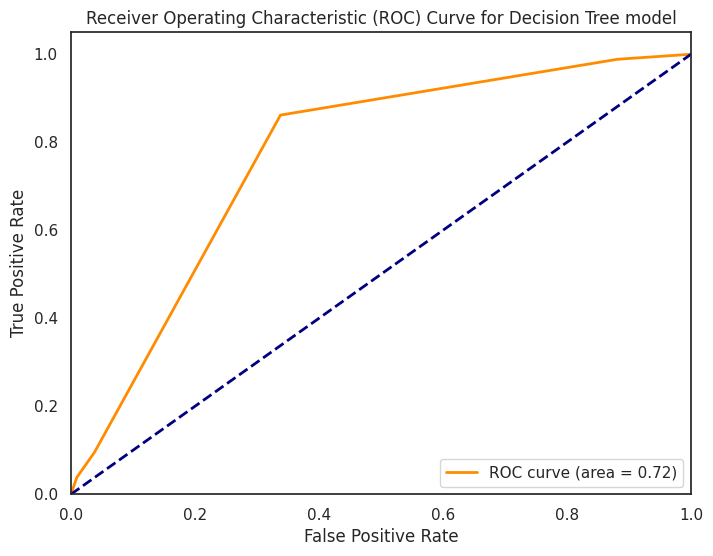

In [33]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define and train your Decision Tree model named 'dtModel'
dtModel = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3).fit(train)

# Use the trained model to make predictions on the test dataset
dtPreds = dtModel.transform(test)

# Import the BinaryClassificationEvaluator for AUC calculation
evaluator = BinaryClassificationEvaluator(labelCol='label')

# Calculate the AUC using the 'evaluate' method on the 'dtPreds' DataFrame
auc_value = evaluator.evaluate(dtPreds, {evaluator.metricName: "areaUnderROC"})

# Print the AUC value
print("Test Area Under ROC: " + str(auc_value))

# Extract probability and label columns as Pandas DataFrame
dtPreds = dtPreds.select("probability", "label").toPandas()

# Get probabilities for the positive class
dtPreds["probability"] = dtPreds["probability"].apply(lambda x: x[1])

# Sort the data by probability for plotting
dtPreds = dtPreds.sort_values(by="probability")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(dtPreds["label"], dtPreds["probability"])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree model')
plt.legend(loc='lower right')
plt.show()

# Random Forest Model

In [34]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[14.1469562070261...|       0.0|[0.70734781035130...|
| 49|management|  0.0|[13.3116597896480...|       0.0|[0.66558298948240...|
| 52|management|  0.0|[8.91770226982461...|       1.0|[0.44588511349123...|
| 53|management|  0.0|[12.4925198824034...|       0.0|[0.62462599412017...|
| 58|management|  0.0|[14.9606185319149...|       0.0|[0.74803092659574...|
| 32|management|  0.0|[14.7425522113100...|       0.0|[0.73712761056550...|
| 57|management|  0.0|[14.4070404168887...|       0.0|[0.72035202084443...|
| 52|management|  0.0|[16.9547368205340...|       0.0|[0.84773684102670...|
| 46|management|  0.0|[16.6352091092,3....|       0.0|[0.83176045545999...|
| 31|management|  0.0|[14.2221331685841...|       0.0|[0.71110665842920...|
+---+-------

Test Area Under ROC: 0.8720283954148549


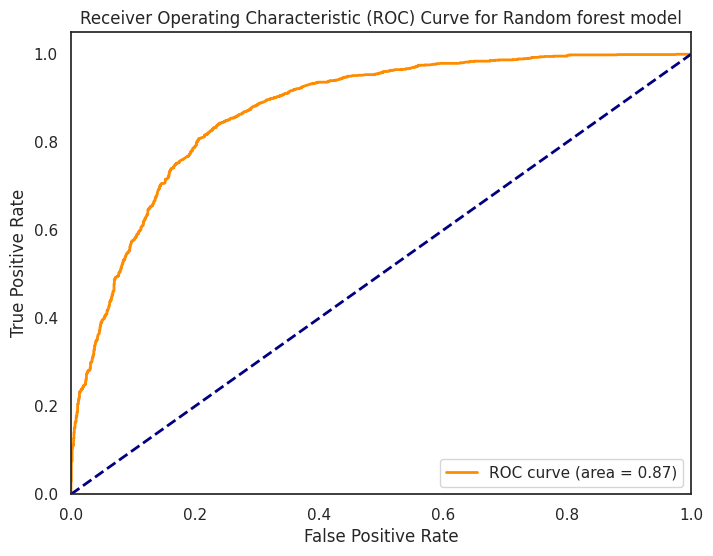

In [35]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Assuming you have defined and trained your RandomForest model named 'rfModel'
rfModel = RandomForestClassifier(featuresCol='features', labelCol='label').fit(train)

# Use the trained model to make predictions on the test dataset
rfPreds = rfModel.transform(test)

# Calculate the ROC curve and AUC using the BinaryClassificationEvaluator
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})

# Print the AUC value
print("Test Area Under ROC: " + str(rfROC))

# Extract probability and label columns as Pandas DataFrame
rfPreds = rfPreds.select("probability", "label").toPandas()

# Get probabilities for the positive class
rfPreds["probability"] = rfPreds["probability"].apply(lambda x: x[1])

# Sort the data by probability for plotting
rfPreds = rfPreds.sort_values(by="probability")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(rfPreds["label"], rfPreds["probability"])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % rfROC)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random forest model')
plt.legend(loc='lower right')
plt.show()

# Gradient Boost Model

In [36]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(test)
gbtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.01465144967175...|       0.0|[0.88383952769458...|
| 49|management|  0.0|[1.27647927187566...|       0.0|[0.92777202098523...|
| 52|management|  0.0|[-0.4712841287377...|       1.0|[0.28038185857952...|
| 53|management|  0.0|[0.27812676220293...|       0.0|[0.63558523575455...|
| 58|management|  0.0|[1.07984111806402...|       0.0|[0.89657008532224...|
| 32|management|  0.0|[0.65315509830971...|       0.0|[0.7868950632428,...|
| 57|management|  0.0|[0.42891412857907...|       0.0|[0.70220671541241...|
| 52|management|  0.0|[1.32475267440024...|       0.0|[0.93398049640317...|
| 46|management|  0.0|[1.19729561208832...|       0.0|[0.91641392634925...|
| 31|management|  0.0|[1.08914127145722...|       0.0|[0.89828225321496...|
+---+-------

Test Area Under ROC: 0.8800975215697069


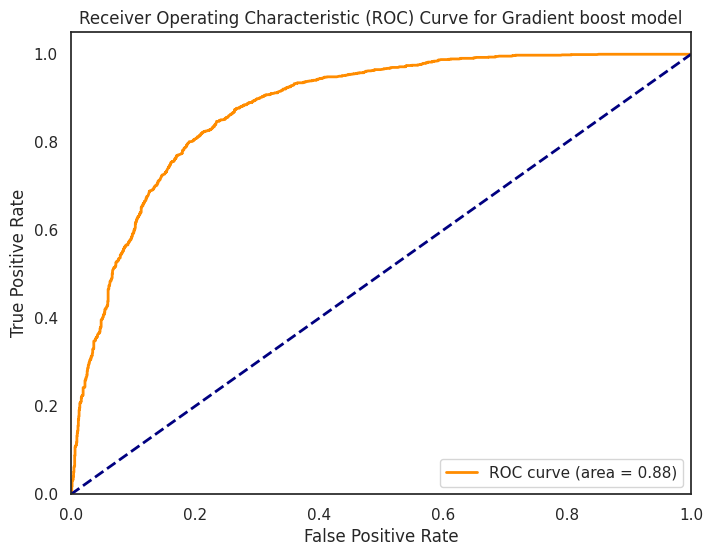

In [37]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming you have defined and trained your GBT model named 'gbtModel'
gbtModel = GBTClassifier(maxIter=10, featuresCol='features', labelCol='label').fit(train)

# Use the trained model to make predictions on the test dataset
gbtPreds = gbtModel.transform(test)

# Calculate the ROC curve and AUC using the BinaryClassificationEvaluator
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})

# Print the AUC value
print("Test Area Under ROC: " + str(gbtROC))

# Extract probability and label columns as Pandas DataFrame
gbtPreds = gbtPreds.select("probability", "label").toPandas()

# Get probabilities for the positive class
gbtPreds["probability"] = gbtPreds["probability"].apply(lambda x: x[1])

# Sort the data by probability for plotting
gbtPreds = gbtPreds.sort_values(by="probability")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(gbtPreds["label"], gbtPreds["probability"])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % gbtROC)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradient boost model')
plt.legend(loc='lower right')
plt.show()

# Cross Validation

Cross-validation provides a more robust and accurate assessment of the model's performance compared to a single train-test split. It helps to ensure that the model's performance metrics are consistent across different data subsets.

In [38]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.881750132348287

# Comparision of all three models

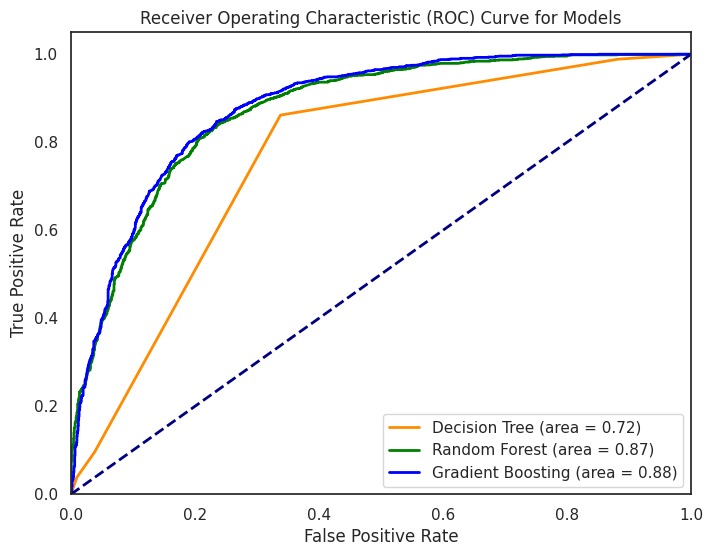

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define and train your Decision Tree model named 'dtModel'
dtModel = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3).fit(train)
# Define and train your Random Forest model named 'rfModel'
rfModel = RandomForestClassifier(featuresCol='features', labelCol='label').fit(train)
# Define and train your Gradient Boosting model named 'gbtModel'
gbtModel = GBTClassifier(maxIter=10, featuresCol='features', labelCol='label').fit(train)

# Calculate ROC curves and AUC values for all three models
models = [dtModel, rfModel, gbtModel]
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
colors = ['darkorange', 'green', 'blue']

plt.figure(figsize=(8, 6))
for model, name, color in zip(models, model_names, colors):
    # Use the trained model to make predictions on the test dataset
    preds = model.transform(test)

    # Import the BinaryClassificationEvaluator for AUC calculation
    evaluator = BinaryClassificationEvaluator(labelCol='label')

    # Calculate the AUC using the 'evaluate' method on the 'preds' DataFrame
    auc_value = evaluator.evaluate(preds, {evaluator.metricName: "areaUnderROC"})

    # Extract probability and label columns as Pandas DataFrame
    preds = preds.select("probability", "label").toPandas()

    # Get probabilities for the positive class
    preds["probability"] = preds["probability"].apply(lambda x: x[1])

    # Sort the data by probability for plotting
    preds = preds.sort_values(by="probability")

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(preds["label"], preds["probability"])

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (area = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Models')
plt.legend(loc='lower right')
plt.show()


# Stopping Spark session

In [40]:
spark.stop()